Decision Tree Model for Building Destruction Classification

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


We start by reading data in from the cal_fire_data_cleaned CSV file:

In [12]:
cal_fire_data = pd.read_csv('../data/cal_fire_data_cleaned.csv')
cal_fire_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42789 entries, 0 to 42788
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   * Structure Type                             42789 non-null  object 
 1   * Roof Construction                          42789 non-null  object 
 2   * Eaves                                      42789 non-null  object 
 3   * Vent Screen                                42789 non-null  object 
 4   * Exterior Siding                            42789 non-null  object 
 5   * Window Pane                                42789 non-null  object 
 6   * Deck/Porch On Grade                        42789 non-null  object 
 7   * Deck/Porch Elevated                        42789 non-null  object 
 8   * Patio Cover/Carport Attached to Structure  42789 non-null  object 
 9   * Fence Attached to Structure                42789 non-null  object 
 10

We set our feature and target variables and then create a pipeline for one-hot encoding the categorical variables and running a decision tree model:

In [13]:
target = 'Destroyed'
X = cal_fire_data.drop(columns=[target])
y = cal_fire_data[target]

categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.difference([target])

# One-hot encoding step
original_columns = cal_fire_data.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  
)

# Pipeline for decision tree modeling
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=216))
])


We create a grid of hyperparameters that we want to test for our decision tree model:

In [14]:
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 4, 6, 8, 10, 12],
    'classifier__min_samples_leaf': [1, 2, 4, 8]
}


We set our feature and target variables and create a train/test split (80%/20%):

In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=216
)


For this model, we perform a grid search that trains a decision tree model on the features, determining the best hyperparameters from our grid to use by determining which gives the best accuracy under k-fold cross-validation. Then, we classify each test observation by applying the best decision tree model.

In [16]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=216)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)
print("best_params:", grid_search.best_params_)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.2s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.2s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.2s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=4; total time=   0.2s
[CV] END classifier__criterion=gini, classifier__max_depth=5

Along with the prediction accuracy, we have a classification report that includes precision, recall, and f1 scores:

In [17]:
from sklearn.metrics import accuracy_score, classification_report

baseline_test_acc = accuracy_score(y_test, y_pred)
print("accuracy: ", baseline_test_acc)
print("\nreport: \n")
print(classification_report(y_test,y_pred))


accuracy:  0.8859546623042767

report: 

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5115
           1       0.88      0.83      0.85      3443

    accuracy                           0.89      8558
   macro avg       0.89      0.88      0.88      8558
weighted avg       0.89      0.89      0.89      8558



We also have a confusion matrix showing how the model performed across classes:

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


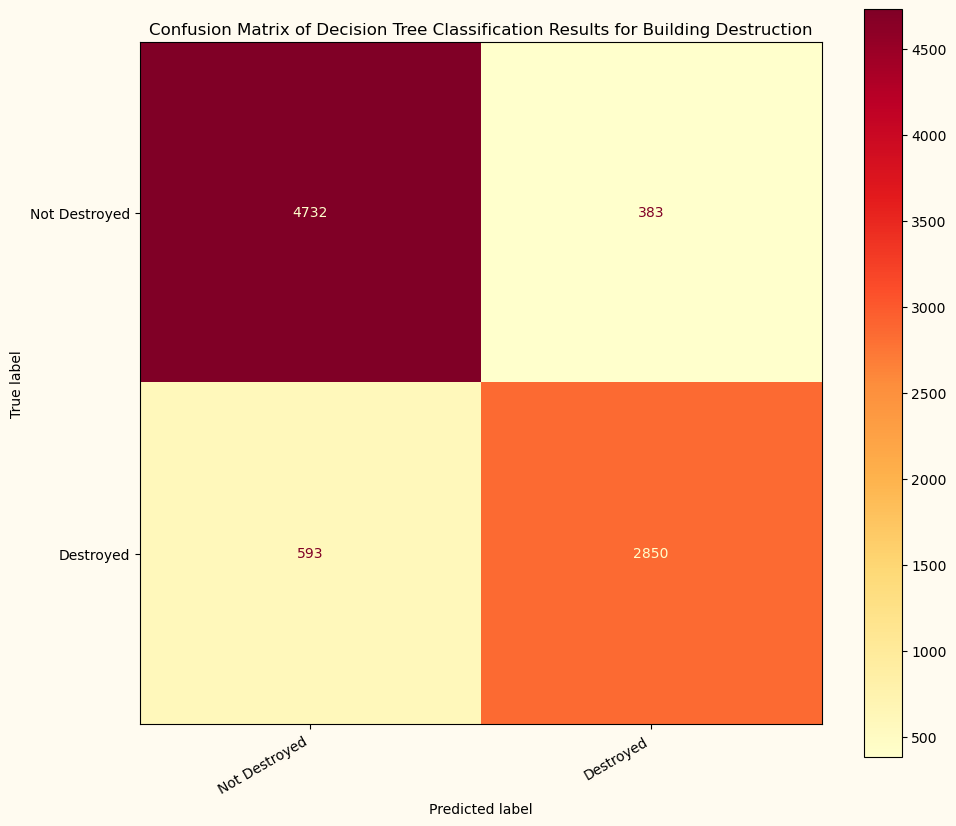

In [19]:
cm = confusion_matrix(y_test, best_tree.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Destroyed', 'Destroyed'])
fig, ax = plt.subplots(figsize=(11, 11), facecolor = ('#fffbf0'))
disp.plot(ax=ax, cmap='YlOrRd')
fig.autofmt_xdate()
plt.title("Confusion Matrix of Decision Tree Classification Results for Building Destruction")
plt.show()


We display feature importances for this model:

In [20]:
from IPython.display import display

# Use impurity-based feature importance (sum across all encodings for each feature)
importances = np.zeros(14)
importances[0] = np.sum(best_tree['classifier'].feature_importances_[0:16])
importances[1] = np.sum(best_tree['classifier'].feature_importances_[16:22])
importances[2] = np.sum(best_tree['classifier'].feature_importances_[22:25])
importances[3] = np.sum(best_tree['classifier'].feature_importances_[25:29])
importances[4] = np.sum(best_tree['classifier'].feature_importances_[29:37])
importances[5] = np.sum(best_tree['classifier'].feature_importances_[37:40])
importances[6] = np.sum(best_tree['classifier'].feature_importances_[40:44])
importances[7] = np.sum(best_tree['classifier'].feature_importances_[44:48])
importances[8] = np.sum(best_tree['classifier'].feature_importances_[48:51])
importances[9] = np.sum(best_tree['classifier'].feature_importances_[51:54])
importances[10:,] = best_tree['classifier'].feature_importances_[54:58]

# Create a new dataframe for feature importances across original feature columns and display it
feature_df = pd.DataFrame({'feature': cal_fire_data.drop(columns='Destroyed').columns, 'importance': importances})
display(feature_df)


,feature,importance
0,* Structure Type,0.016584
1,* Roof Construction,0.003441
2,* Eaves,0.013425
3,* Vent Screen,0.012478
4,* Exterior Siding,0.030284
5,* Window Pane,0.015083
6,* Deck/Porch On Grade,0.005880
7,* Deck/Porch Elevated,0.002683
8,* Patio Cover/Carport Attached to Structure,0.001198
9,* Fence Attached to Structure,0.009157


For this model, the most important features were latitude and longitude.